In [2]:
# Importación de las librerías de los widgets, numpy para el manejo de vectores y operaciones con arreglos, pandas para la 
# extracción de tablas y características, io para funciones del sistema y display para mostrar los widgets en nuestro 
# notebook
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random

from io import StringIO
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from statistics import mode


In [13]:
# Delimitador de los valores en el archivo
delim = ","

#Número de filas que se excluyen del set de datos (Observaciones, atributos y clases)
rows = 3

#Widget para ingresar un valor entero
w = widgets.IntSlider(
    value=2,
    min=2,
    max=12,
    step=1,
    description='#',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
#Widget para obtener un valor entero
Folds = widgets.IntSlider(
    value=2,
    min=2,
    max=10,
    step=1,
    description='#',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

#Botón de comienzo del ensamble
Start = widgets.Button(
        description='Comenzar',
        disabled=False,
        button_style='', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Comenzar ensamble',
        icon='check' # (FontAwesome names without the `fa-` prefix)
        )

#Widget para el botón que carga los datos y actualiza los límites de los widgets
b = widgets.Button(
    description='Cargar datos',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Cargar datos',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

#Widget de salida
output = widgets.Output()


#Widget para subir el archivo
up= widgets.FileUpload(
    accept='',  # Archivos o extenciones válidas. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False  # Cambiar a verdadero para aceptar más de un archivo pero no está soportado por la secuencia de lectura
)

# Convertidor del archivo
# Cuando se usa el widget para subir archivos, el formato en el que arroja el documento no puede usarse directamente en la 
# función read_csv de pandas ya que la estructura es un JSON.

# Se tiene que extraer el contenido de una serie de etiquetas, siendo la última (content) la
# importante. Esta función sólo extrae de la etiqueta content el archivo leido para luego pasarlo a una cadena o buffer
# con formato utf-8 que la función read_csv pueda leer.

def content_parser():
    # Si el contenido de up no tiene nada, entonces se manda el mensaje de error
    
    if up.value == {}:
        # with output se encarga de mostrar valores en el widget de salida (output)
        with output:
            print('No CSV loaded')    
    else:
        # Inicialización de las variables typ y content
        typ, content = "", ""
        
        # Extracción del contenido del widget up
        up_value = up.value
        
        # Recorre internamente la estructura del JSON que se obtuvo del widget up
        for i in up_value.keys():
            
            # Del valor value de nuestra variable up se extrae el componente type de metadata para verificar que es un
            # archivo soportado
            
            typ = up_value[i]["metadata"]["type"]
            
            # Verificación del tipo de archivo
            
            if typ == "application/vnd.ms-excel" or typ == "text/plain":
                # Extracción del contenido de la etiqueta content
                content = up_value[i]["content"]
                content_str = str(content, 'utf-8')
                
                if content_str != "":
                    str_io = StringIO(content_str) 
                    return str_io

def on_b_clicked(b):
    # Llamado a la función que permite parsear el contenido
    content = content_parser()
    
    #Si no se regresa un valor parseado entonces no se ejecuta nada de código y sólo se muestra el mensaje de error
    if content is not None:
        # Lectura del csv desde el buffer de memoria content, quitando los indices de las columnas, estableciendo el
        # delimitador del contenido y quitando el header que pueda 
        data = pd.read_csv(content, index_col=False, sep=delim, header=None)
        
        # Extracción de las dimensiones de nuestro archivo, para poder determinar el final de las características y de las
        # observaciones
        xDim, yDim = data.shape
        
        # Extracción del número de observaciones, atributos y clases de nuestros datos
        noObservations = data[0][0]    
        noAttributes = data[0][1]
        noClasses = data[0][2]
        
        # Impresión de los valores obtenidos
        print("Información de los datos cargados: ")
        print("# de Observaciones {}".format(noObservations))
        print("# de Atributos {}".format(noAttributes))
        print("# de Clases {}".format(noClasses))
        
        w.max = noAttributes
        # Extracción de las primeras n columnas que corresponden a las características de los datos
        # Se elimina también la columna de los índices para reiniciar el contador y no empezar desde 3
        # Se debe tomar en cuenta que la dimensión en Y es mayor que la dimensión total, por ejemplo, si el dataset
        # tiene de 0 a 15 características, entonces la dimensión de Y será de 16, por eso se le resta uno a la dimensión Y
        global dataSet
        dataSet = data.iloc[rows:,:yDim].reset_index(drop=True)
        
        # Extracción de la columna que contiene a las clases de nuestro data set
        # Se sigue el mismo proceso, pero ahora se mantiene sólo la última columna. Se deja entre [] para que el resultado
        # se quede en las mismas condiciones que el anterior
        global classes
        classes = data.iloc[rows:,yDim - 1 ].reset_index(drop=True)
        # Impresión del data set (primeros 5 valores) y de las clases
        print(dataSet.head())
        print("\n")
        print(classes.head())
        print("\n")
        display(Start)
                
#Función para ejecutarse cuando el botón "Comenzar" se active
def on_Start_clicked(Start):
    
        NoComp = w.value
        #dataSet.head()
        pca = PCA(n_components=NoComp)
        
        print("Comenzando PCA con los componentes elegidos\n")
        
        global X_std
        X_std = StandardScaler().fit_transform(dataSet)

        pca.fit(X_std)
        global DatosPCA
        DatosPCA = pca.transform(X_std)
    
        print("Radio de varianza")
        print(pca.explained_variance_ratio_)
        print("\n")
        print("Valores singulares")
        print(pca.singular_values_)
        print("\n")
        print("Matriz de proyección")
        print((pca.components_).T)
        print("\n")
        folds = Folds.value
        # Naive Bayes
        X = DatosPCA
        y = classes.values
    
        #Arreglos de predicciones del ensamble para un elemento
        y_pred_Ensamble = []
    
        #Arreglos de efectividad parciales de los clasificadores
        ParcialesBayes = []
        ParcialesPercep = []
        ParcialesArbol = []
        ParcialesEnsamble = []
    
        kf = StratifiedKFold( n_splits = folds , shuffle = True , random_state = None )
    
    #     for train_index, test_index in kf.split(X, y):
    #         #print("TRAIN:", train_index, "TEST:", test_index)
    #         X_train, X_test = X[train_index], X[test_index]    
    #         y_train, y_test = y[train_index], y[test_index]
    
    #    for i,split in enumerate kf.split(X, y):
        for train_index, test_index in kf.split(X, y):
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
        
            #print( "    Comienzo del entrenamiento, vuelta {}".format(i))
            #Bayes
            bayes_ingenuo = GaussianNB()
            # predicción 
            y_pred = bayes_ingenuo.fit(X_train, y_train).predict(X_test)
            # Matriz de confusión
            cnf_matrix = confusion_matrix(y_test, y_pred)
            ResBayes = 1 - (y_test != y_pred).sum()/y_test.shape[0]
            ParcialesBayes.append(ResBayes)
            print("Aplicando Naive Bayes sobre datos luego del PCA")
            print("Cantidad de errores de clasificación sobre un total de {0} casos: {1}"
                    .format(y_test.shape[0],(y_test != y_pred).sum()))
            print("Efectividad del algoritmo: {0: .2f}"
                    .format(ResBayes))
            # Graficando la matriz de confusión
            sns.heatmap(cnf_matrix.T, square=True, annot=True, fmt='d', cbar=False)
            plt.xlabel('Clase verdadera')
            plt.ylabel('Clase predecida')
            plt.title('Matriz de Confusión')
            plt.show()

            #Perceptron
            ppn = Perceptron( eta0=0.1, random_state=0)
            ppn.fit(X_train, y_train)
            y_predA = ppn.predict(X_test)
        
            cnf_matrix2 = confusion_matrix(y_test, y_predA)
            ResPercep = 1 - (y_test != y_predA).sum()/y_test.shape[0]
            ParcialesPercep.append(ResPercep)
            print("Aplicando Perceptrón sobre datos luego del PCA")
            print("Número de iteraciones")
            print(ppn.n_iter_)
            print("Cantidad de errores de clasificación sobre un total de {0} casos: {1}"
                    .format(y_test.shape[0],(y_test != y_predA).sum()))
            print("Efectividad del algoritmo: {0: .2f}"
                    .format(ResPercep))
            # Graficando la matriz de confusión
            sns.heatmap(cnf_matrix2.T, square=True, annot=True, fmt='d', cbar=False)
            plt.xlabel('Clase verdadera')
            plt.ylabel('Clase predecida')
            plt.title('Matriz de Confusión')
            plt.show()
    
    
            #Arbol de decisión
            clf = DecisionTreeClassifier()
            clf = clf.fit(X_train ,y_train)
            y_predP = clf.predict(X_test)

            cnf_matrix3 = confusion_matrix(y_test, y_predP)
            ResArbol = 1 - (y_test != y_predP).sum()/y_test.shape[0]
            ParcialesArbol.append(ResArbol)
            print("Aplicando Árbol de decisión sobre datos luego del PCA")
            print("Cantidad de errores de clasificación sobre un total de {0} casos: {1}"
                    .format(y_test.shape[0],(y_test != y_predP).sum()))
            print("Efectividad del algoritmo: {0: .2f}"
                    .format(ResArbol))
            # Graficando la matriz de confusión
            sns.heatmap(cnf_matrix3.T, square=True, annot=True, fmt='d', cbar=False)
            plt.xlabel('Clase verdadera')
            plt.ylabel('Clase predecida')
            plt.title('Matriz de Confusión')
            plt.show()
    
            #Ensamble sobre resultados parciales
    
            for i in range(len(y_pred)):
                y1 = y_pred[i]
                y2 = y_predP[i]
                y3 = y_predA[i]
                x = [y1, y2, y3]
                if y1 != y2 and y1 != y3 and y2 != y3 :
                    y_pred_Ensamble.append(random.choice(x))
                else :
                    y_pred_Ensamble.append(mode(x))

            cnf_matrixEnsamble = confusion_matrix(y_test, y_pred_Ensamble)
            ResEnsamble = 1 - (y_test != y_pred_Ensamble).sum()/y_test.shape[0]
            ParcialesEnsamble.append(ResEnsamble)
            print("Aplicando el ensamble, resultados parciales")
            print("Cantidad de errores de clasificación sobre un total de {0} casos: {1}"
                    .format(y_test.shape[0],(y_test != y_pred_Ensamble).sum()))
            print("Efectividad del algoritmo: {0: .2f}"
                    .format(ResEnsamble))
            # Graficando la matriz de confusión
            sns.heatmap(cnf_matrixEnsamble.T, square=True, annot=True, fmt='d', cbar=False)
            plt.xlabel('Clase verdadera')
            plt.ylabel('Clase predecida')
            plt.title('Matriz de Confusión')
            plt.show()
            y_pred_Ensamble = []

        print("Resultados de efectividad promedio:")
        avgBay = sum(ParcialesBayes)/len(ParcialesBayes)
        avgPer = sum(ParcialesPercep)/len(ParcialesPercep)
        avgArb = sum(ParcialesArbol)/len(ParcialesArbol)
        avgEns = sum(ParcialesEnsamble)/len(ParcialesEnsamble)

        print("Naive Bayes: ")
        print(avgBay)

        print("Perceptrón: ")
        print(avgPer)

        print("Árbol de decisión: ")
        print(avgArb)

        print("Ensamble aplicado: ")
        print(avgEns)
           
    
    # Asignación de la función on_button_clicked al evento on_click del botón b 
Start.on_click(on_Start_clicked)
b.on_click(on_b_clicked)

Cargue el archivo .txt o .csv que contiene los datos a analizar y presione el botón cuando esté listo


FileUpload(value={}, description='Upload')

Button(description='Cargar datos', icon='check', style=ButtonStyle(), tooltip='Cargar datos')


Ingrese el número de componentes para el proceso de PCA


IntSlider(value=2, continuous_update=False, description='#', max=12, min=2)


Elija el número de pliegues para la validación cruzada


IntSlider(value=2, continuous_update=False, description='#', max=10, min=2)

Output()



Si los datos son correctos, presione el botón para comenzar 


Información de los datos cargados: 
# de Observaciones 409.0
# de Atributos 385.0
# de Clases 6.0
        0         1         2         3         4         5    6     7    \
0  0.622490  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.00   
1  0.630137  0.400524  0.421793  0.850483  0.734300  0.000000  0.0 -0.25   
2  0.657718  0.773077  0.850657  0.753205  0.000000  0.000000  0.0 -0.25   
3  0.683544  0.573705  0.323887  0.824176  0.728665  0.000000  0.0 -0.25   
4  0.000000  0.000000  0.000000  0.000000  0.196364  0.947141  0.0 -0.25   

    8     9    ...  376      377       378       379  380  381   382   383  \
0  0.00 -0.25  ...  0.0  0.00000  0.000000  0.000000  0.0  0.0  0.00  0.00   
1 -0.25 -0.25  ...  0.0  0.97244  0.995384  0.997934  0.0  0.0 -0.25 -0.25   
2 -0.25 -0.25  ...  0.0  0.95305  0.986386  0.993740  0.0  0.0 -0.25 -0.25   
3 -0.25 -0.25  ...  0.0  0.00000  0.995114  0.997632  0.0  0.0 -0.25

Button(description='Comenzar', icon='check', style=ButtonStyle(), tooltip='Comenzar ensamble')

Comenzando PCA con los componentes elegidos

Radio de varianza
[2.12746157e-01 1.44700058e-01 1.02635540e-01 6.72662508e-02
 5.20763417e-02 4.48735955e-02 2.82287083e-02 2.57766140e-02
 2.27943688e-02 1.85915672e-02 1.83362388e-02 1.66341423e-02
 1.42870224e-02 1.27026907e-02 1.21802405e-02 1.10874956e-02
 1.05003528e-02 9.74331886e-03 9.25144592e-03 8.42957367e-03
 7.91866958e-03 7.27029532e-03 6.71419611e-03 6.11868330e-03
 5.51526180e-03 5.28364362e-03 4.86270637e-03 4.76972576e-03
 4.53602326e-03 4.22871305e-03 3.81401813e-03 3.58041503e-03
 3.46345182e-03 3.31789465e-03 3.11128904e-03 3.06991755e-03
 2.94512434e-03 2.84753852e-03 2.60320697e-03 2.56703234e-03
 2.37683741e-03 2.21954525e-03 2.16768310e-03 2.05248866e-03
 2.00045966e-03 1.94888448e-03 1.86496927e-03 1.83633673e-03
 1.75712666e-03 1.69224573e-03 1.60217651e-03 1.53297207e-03
 1.46517094e-03 1.41426051e-03 1.38234875e-03 1.32368108e-03
 1.27606344e-03 1.24057284e-03 1.16788583e-03 1.07942743e-03
 1.04129976e-03 9.7390

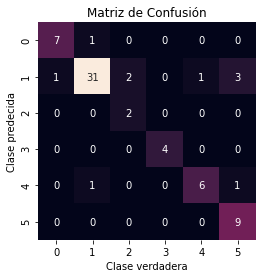

Aplicando Perceptrón sobre datos luego del PCA
Número de iteraciones
13
Cantidad de errores de clasificación sobre un total de 69 casos: 1
Efectividad del algoritmo:  0.99


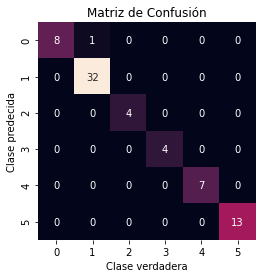

Aplicando Árbol de decisión sobre datos luego del PCA
Cantidad de errores de clasificación sobre un total de 69 casos: 6
Efectividad del algoritmo:  0.91


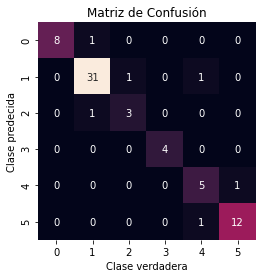

Aplicando el ensamble, resultados parciales
Cantidad de errores de clasificación sobre un total de 69 casos: 3
Efectividad del algoritmo:  0.96


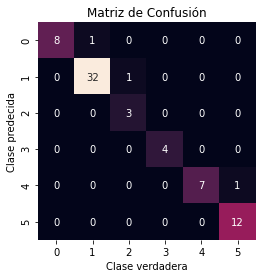

Aplicando Naive Bayes sobre datos luego del PCA
Cantidad de errores de clasificación sobre un total de 68 casos: 5
Efectividad del algoritmo:  0.93


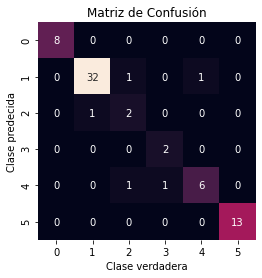

Aplicando Perceptrón sobre datos luego del PCA
Número de iteraciones
14
Cantidad de errores de clasificación sobre un total de 68 casos: 1
Efectividad del algoritmo:  0.99


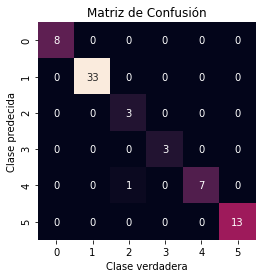

Aplicando Árbol de decisión sobre datos luego del PCA
Cantidad de errores de clasificación sobre un total de 68 casos: 3
Efectividad del algoritmo:  0.96


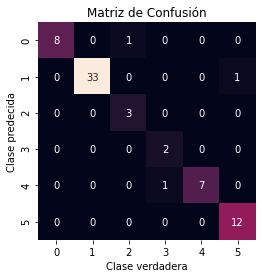

Aplicando el ensamble, resultados parciales
Cantidad de errores de clasificación sobre un total de 68 casos: 2
Efectividad del algoritmo:  0.97


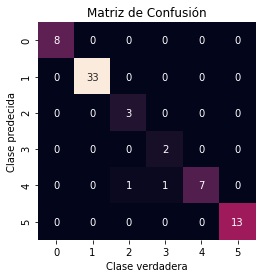

Aplicando Naive Bayes sobre datos luego del PCA
Cantidad de errores de clasificación sobre un total de 68 casos: 5
Efectividad del algoritmo:  0.93


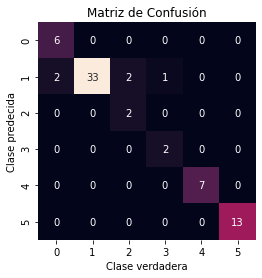

Aplicando Perceptrón sobre datos luego del PCA
Número de iteraciones
13
Cantidad de errores de clasificación sobre un total de 68 casos: 0
Efectividad del algoritmo:  1.00


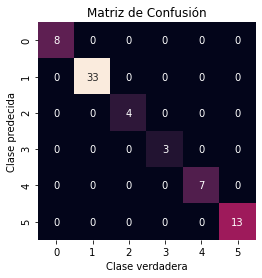

Aplicando Árbol de decisión sobre datos luego del PCA
Cantidad de errores de clasificación sobre un total de 68 casos: 2
Efectividad del algoritmo:  0.97


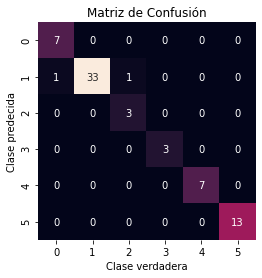

Aplicando el ensamble, resultados parciales
Cantidad de errores de clasificación sobre un total de 68 casos: 1
Efectividad del algoritmo:  0.99


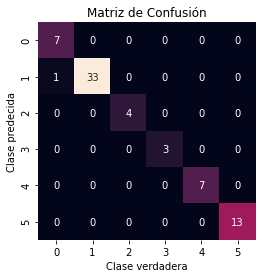

In [14]:
print("Cargue el archivo .txt o .csv que contiene los datos a analizar y presione el botón cuando esté listo")
display(up, b)
print("\nIngrese el número de componentes para el proceso de PCA")
display(w)
print("\nElija el número de pliegues para la validación cruzada")
display(Folds, output)
print("\n\nSi los datos son correctos, presione el botón para comenzar \n\n")